# 1a. Reading
This article "Predicting Healthcare Fraud in Medicaid: A Multidimensional
Data Model and Analysis Techniques for Fraud Detection" articulates the big picture of healthcare fraud and scientific techniques in analyzing these frauds. The paper disused the environment, the types of frauds, and the techniques to address these frauds. As a person who is not very well-versed with the industry, I find this paper very laymen friendly. It starts off with a discussion of the different parties within the healthcare system and their roles (patient, provider, insurer, and Federal CMS). Then, a detailed seven levels of fraud were depicted. Level 1 fraud starts off at a single transaction level, and level 7 is at a broad municipality level. Then for each subdivided level of fraud, a scientific solution using data analytic was discussed and explained. I really like this paper, as it produced a great pavement to start off this week's class. 

In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%autosave 180
%matplotlib inline

Autosaving every 180 seconds


In [2]:
data = pd.read_csv("/Users/aston/Desktop/CU2020Summer/M3/HW3/inpatientCharges.csv")

In [3]:
#recrod the definition of each column
definition = {'DRG':'Classification system that groups similar clinical conditions (diagnoses) and the procedures furnished by the hospital during the stay.',
             'Total Discharges': 'The number of discharges billed by all providers for inpatient hospital services.',
             'AverageCovered':"The average charge of all provider's services covered by Medicare for discharges in the DRG. These will vary from hospital to hospital because of differences in hospital charge structures.",
             'AverageTotal':'The average total payments to all providers for the DRG including the MS-DRG amount, teaching,  disproportionate share, capital, and outlier payments for all cases. Also included in average total payments are co-payment and deductible amounts that the patient is responsible for and any additional payments by third parties for coordination of benefits.',
             'AverageMedicare':'The average amount that Medicare pays to the provider for Medicares share of the MS-DRG. Medicare payment amounts include the MS-DRG amount, teaching,  disproportionate share, capital, and outlier payments for all cases. Medicare payments DO NOT include beneficiary co-payments and deductible amounts nor any additional payments from third parties for coordination of benefits.',
             'AverageCopay': 'AverageTotal - AverageMedicare'}

In [4]:
#gets rid of the white space on both the left and right of each column
data.columns = data.columns.str.lstrip()
data.columns = data.columns.str.rstrip()

In [5]:
#changes the dtype of some columns into floats
data['Average Covered Charges']= data['Average Covered Charges'].replace('[\$,]', '', regex=True).astype(float)
data['Average Total Payments']= data['Average Total Payments'].replace('[\$,]', '', regex=True).astype(float)
data['Average Medicare Payments']= data['Average Medicare Payments'].replace('[\$,]', '', regex=True).astype(float)

In [6]:
# calculate the amount of copy or 'out of pocket' cost to individual
data['Average Copay']= data['Average Total Payments'] - data['Average Medicare Payments']

In [7]:
#understand the size of the dataset and each variable
print(data.shape)
data.head()

(163065, 13)


,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Average Copay
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,4763.73,1013.51
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,4976.71,810.86
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,4453.79,981.16
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.28,5417.56,4129.16,1288.40
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,31633.27,5658.33,4851.44,806.89


In [8]:
# see the number of unique values in each column 
l1 = []
for col in data.columns:
    l1.append(data[col].unique().shape[0])
l2 = data.columns.tolist()
uniquedf = pd.DataFrame({'Column' : l2,
                                'UniqueCount' : l1 }, 
                                columns=['Column','UniqueCount'])
uniquedf.head()

,Column,UniqueCount
0,DRG Definition,100
1,Provider Id,3337
2,Provider Name,3201
3,Provider Street Address,3326
4,Provider City,1977


In [9]:
data.describe().head()

,Provider Id,Provider Zip Code,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Average Copay
count,163065.000000,163065.000000,163065.000000,163065.000000,163065.000000,163065.000000,163065.000000
mean,255569.865428,47938.121908,42.776304,36133.954224,9707.473804,8494.490964,1212.982840
std,151563.671767,27854.323080,51.104042,35065.365931,7664.642598,7309.467261,1148.097584
min,10001.000000,1040.000000,11.000000,2459.400000,2673.000000,1148.900000,0.000000
25%,110092.000000,27261.000000,17.000000,15947.160000,5234.500000,4192.350000,776.310000


In [10]:
#no duplicate rows in this dataset
duplicateData = data[data.duplicated()]
duplicateData

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Average Copay


# Exploratory Data Analysis

# Groupby Provider IDs
***

## F1 Explore the mismatch between the number of Providers and Provider IDs
Lead: I want to examine the reasons for one provider name having multiple provider ID.
I will groupby 'Provider Name' and count the number of values in each group.


In [11]:
f1 = data.groupby(['Provider Name']).nunique().copy()
f1.sort_values(by='Provider Id',ascending=False)
f1 = pd.DataFrame(f1)
f1.rename(columns= {'Provider Id':'Provider Id Count'},inplace = True)
f1 = f1.drop(columns='Provider Name')
f1.reset_index(inplace = True)
f1[['Provider Name','Provider Id Count']].sort_values(by = 'Provider Id Count', ascending = False)

,Provider Name,Provider Id Count
924,GOOD SAMARITAN HOSPITAL,9
2642,ST JOSEPH HOSPITAL,7
2644,ST JOSEPH MEDICAL CENTER,6
2614,ST FRANCIS HOSPITAL,6
1645,MERCY HOSPITAL,6
...,...,...
1082,HILLCREST MEMORIAL HOSPITAL,1
1083,HILLSDALE COMMUNITY HEALTH CENTER,1
1084,HILLSIDE HOSPITAL,1
1085,HILO MEDICAL CENTER,1


In [12]:
f1= f1[f1['Provider Id Count']>=2]
f1.head()

,Provider Name,DRG Definition,Provider Id Count,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Average Copay
12,ADVENTIST MEDICAL CENTER,78,2,2,2,2,2,2,56,113,113,113,113
96,ATHENS REGIONAL MEDICAL CENTER,96,2,2,1,2,2,2,64,122,122,122,122
116,AURORA MEDICAL CENTER,24,2,2,2,1,2,1,15,32,31,32,32
148,BAPTIST HOSPITAL,92,2,2,2,2,2,2,68,170,170,170,169
152,BAPTIST MEDICAL CENTER,100,2,2,2,2,2,2,118,200,200,199,199


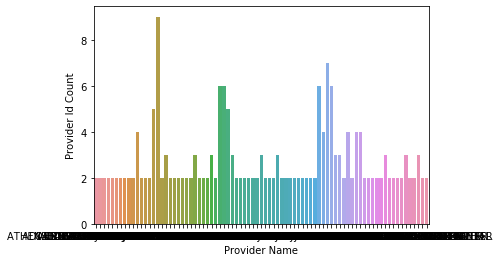

In [13]:
#There are some outliers where some provider names have over 100 provider IDs.
sns.barplot(x='Provider Name', y='Provider Id Count', data=f1, order=None)

In [14]:
#I see that this provider has multiple location and thus have many different provider IDs
d1 = data[data['Provider Name']=='GOOD SAMARITAN HOSPITAL'].copy()
d1.groupby(['Provider City','Provider State']).nunique().count()

DRG Definition                          9
Provider Id                             9
Provider Name                           9
Provider Street Address                 9
Provider City                           9
Provider State                          9
Provider Zip Code                       9
Hospital Referral Region Description    9
Total Discharges                        9
Average Covered Charges                 9
Average Total Payments                  9
Average Medicare Payments               9
Average Copay                           9
dtype: int64

## This is not an anomaly. This would also explain the mismatch between addresses, zipcodes, provider names, and provider ids. Since provider IDs are the largest of them all, I will use Provider IDs as a unique identifier from now on


# F2 For Good Samaritan Hospital, and groupby the DRG code, I am looking for the largest discrepency in payment between state by calculating the standardized distance for the max Average Medicare Payment to the mean.

In [15]:
f22= d1.groupby('DRG Definition')['Average Medicare Payments'].describe().copy()
f22['STD'] = (f22['max']-f22['mean'])/f22['std']
f22.reset_index(inplace = True)
f22.head()

,DRG Definition,count,mean,std,min,25%,50%,75%,max,STD
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,6.0,6089.281667,869.606672,4716.21,5686.7800,6162.340,6665.8750,7132.82,1.200012
1,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,5.0,5634.302000,1122.756138,4376.57,5051.5600,5100.750,6726.0000,6916.63,1.142125
2,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,7.0,12992.725714,2997.435859,8619.41,11238.8750,12954.930,14509.2550,17878.48,1.629978
3,065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,8.0,7132.507500,1578.703895,5129.28,6331.4725,6848.755,7686.3625,9934.25,1.774711
4,066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,8.0,4774.676250,1126.824277,3290.29,4086.1250,4682.325,5309.9125,6749.22,1.752308


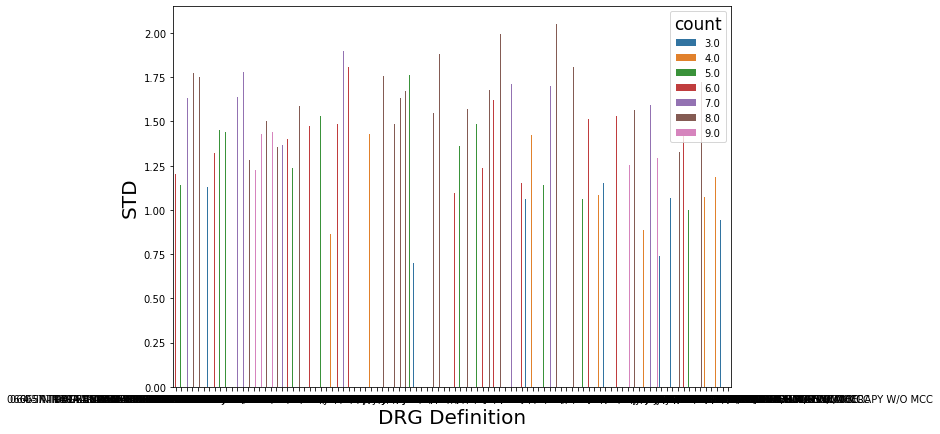

In [16]:
# looking for the largest standard deviation by disseas, based on Average Medicare Payments
plt.figure(figsize=(10, 7))
plt.rcParams["axes.labelsize"] = 20
b = sns.barplot(x='DRG Definition', y='STD', hue= 'count', data=f22, order=None)

In [17]:
f22[f22['STD']>2]

,DRG Definition,count,mean,std,min,25%,50%,75%,max,STD
68,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,8.0,14043.58125,4466.177288,9675.93,11127.91,12526.12,15740.1575,23191.55,2.048277


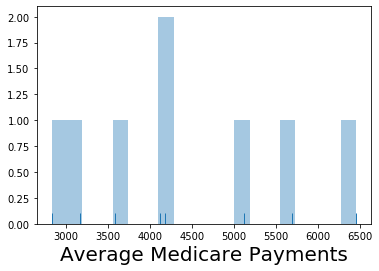

In [18]:
#the chart shows the distribution of Average Medical Payments. 
#One hospital charges, on average 6400 in medical payment for 293 illness, 
#whereas another hospital for the same chain charges 2800 on average. 
f222 = data[(data['DRG Definition']=='293 - HEART FAILURE & SHOCK W/O CC/MCC') &(data['Provider Name']=='GOOD SAMARITAN HOSPITAL')].copy()
sns.distplot(f222['Average Medicare Payments'], kde=False, rug=True, bins= 20);

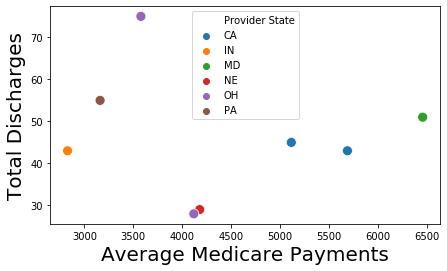

In [19]:
#the purple and blue dots are close to each other in terms of horizontal distance, 
#meaning the price they charge does not vary a lot
#sample size for these charges are large enough, most of them are greater than 30.
plt.figure(figsize=(7, 4))
ax = sns.scatterplot(x = 'Average Medicare Payments', y = 'Total Discharges', hue='Provider State' , s = 100,  data = f222)

In [20]:
f22[f22['STD']>1.9]

,DRG Definition,count,mean,std,min,25%,50%,75%,max,STD
5,069 - TRANSIENT ISCHEMIA,8.0,4080.86625,993.908236,3015.96,3339.1450,3942.16,4463.9250,6029.25,1.960326
58,389 - G.I. OBSTRUCTION W CC,8.0,5605.94625,1171.417556,4194.71,4909.5975,5545.35,5838.3550,7940.33,1.992785
68,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,8.0,14043.58125,4466.177288,9675.93,11127.9100,12526.12,15740.1575,23191.55,2.048277


## There should be some investigation into the Good Samaritan Hospital Chain, and see why is there an over charge for the hospital in Maryland for 293, Heart Failure. Likewise for other two diseases in other branches.

# F3 See if there is situation where there is no 'out of pocket' cost, which might entice fraudsters to take advantage of this.

In [21]:
data[data['Average Copay']==0]

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Average Copay
90877,372 - MAJOR GASTROINTESTINAL DISORDERS & PERIT...,340173,"WAKEMED, CARY HOSPITAL",1900 KILDARE FARM ROAD,CARY,NC,27511,NC - Raleigh,13,22776.61,7299.07,7299.07,0.0


In [22]:
# find out why there is no out of pocket cost
f3 = data[data['Provider Name']=='WAKEMED, CARY HOSPITAL'].copy()
f3.groupby('DRG Definition')['Average Copay'].describe().sort_values(by='max',ascending=True).head()

,count,mean,std,min,25%,50%,75%,max
DRG Definition,,,,,,,,
372 - MAJOR GASTROINTESTINAL DISORDERS & PERITONEAL INFECTIONS W CC,1.0,0.00,NaN,0.00,0.00,0.00,0.00,0.00
314 - OTHER CIRCULATORY SYSTEM DIAGNOSES W MCC,1.0,460.18,NaN,460.18,460.18,460.18,460.18,460.18
948 - SIGNS & SYMPTOMS W/O MCC,1.0,601.60,NaN,601.60,601.60,601.60,601.60,601.60
177 - RESPIRATORY INFECTIONS & INFLAMMATIONS W MCC,1.0,609.17,NaN,609.17,609.17,609.17,609.17,609.17
682 - RENAL FAILURE W MCC,1.0,609.94,NaN,609.94,609.94,609.94,609.94,609.94


In [23]:
#calculate the percentage medicare ratio and take only the numeric values to create a corrplot
f3['PercentageMedicare'] = f3['Average Medicare Payments']/f3['Average Total Payments']
f3.sort_values(by='PercentageMedicare', ascending=False,inplace=True)
cor1 = f3[['Provider Id','Provider Zip Code','Total Discharges','Average Covered Charges','Average Total Payments',
          'Average Medicare Payments','Average Copay','PercentageMedicare']]

In [24]:
# the CoveredCharges are positively related with TotalPayments, MedicarePayments, Average Copay, and Percentage.
# CoveredCharges is negatively related to Totaldischarges.
corr = cor1.corr()
corr.head()

,Provider Id,Provider Zip Code,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Average Copay,PercentageMedicare
Provider Id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Provider Zip Code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total Discharges,NaN,NaN,1.000000,-0.13741,-0.134108,-0.129101,-0.085164,0.030859
Average Covered Charges,NaN,NaN,-0.137410,1.00000,0.924640,0.914102,0.325162,0.564656
Average Total Payments,NaN,NaN,-0.134108,0.92464,1.000000,0.996107,0.269684,0.612532


In [25]:
#calculate the national PercentageMedicare
d3 = data.copy()
d3['PercentageMedicare'] = d3['Average Medicare Payments']/d3['Average Total Payments']
d3['PercentageMedicare'].mean()

0.8465447820733937

In [26]:
#this hospital's PercentageMedicare is close to national average
f3['PercentageMedicare'].mean()

0.8254797164720173

## Insight: Though there was one instance in the whole dataset where the Average Copay was 0. The average Medicare payment for this provider is similar to that of the national average. 

# F4 Explore the PercentageMedicare when applied to the whole dataset

In [27]:
f4 = d3.groupby('Provider Id')['PercentageMedicare'].describe()
f4.sort_values(by='mean', ascending=False, inplace =True)
f4.reset_index(inplace=True)
f4.head()

,Provider Id,count,mean,std,min,25%,50%,75%,max
0,50528,8.0,0.964869,0.012237,0.943903,0.959029,0.968831,0.973815,0.977627
1,50677,1.0,0.962815,NaN,0.962815,0.962815,0.962815,0.962815,0.962815
2,50376,19.0,0.951555,0.026877,0.887451,0.937371,0.955771,0.972676,0.991397
3,530015,3.0,0.950449,0.026812,0.922253,0.937862,0.953471,0.964547,0.975622
4,370220,2.0,0.950217,0.018002,0.937488,0.943852,0.950217,0.956581,0.962946


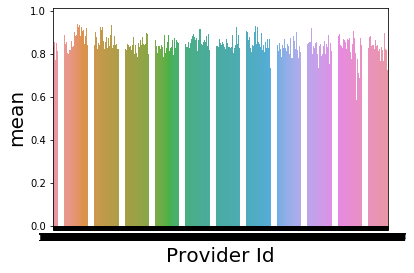

In [28]:
sns.barplot(x='Provider Id', y='mean', data=f4, order=None)

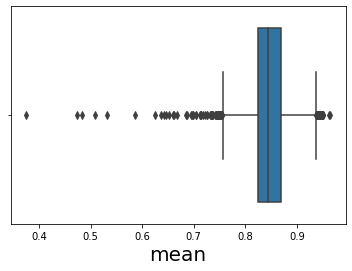

In [29]:
#outliers below 0.4
sns.boxplot(x=f4["mean"])

In [30]:
f4[f4['mean']<0.6]['Provider Id'].tolist()

[450880, 190245, 120011, 390312, 450874, 140100]

## The above list contains the Provider Ids that have extremely low Percentage Medicare payment ratio.

# F5 Explore which provider ID has the greatest number of ONETIME discharges.

In [31]:
f5 = data.groupby('Provider Id')['Total Discharges'].describe().copy()
f5.sort_values(by='max',ascending=False).head()

,count,mean,std,min,25%,50%,75%,max
Provider Id,,,,,,,,
330270,8.0,494.500000,1169.607871,14.0,25.5,62.5,168.50,3383.0
50024,46.0,68.478261,247.234188,11.0,16.0,23.5,37.75,1696.0
220062,1.0,1571.000000,NaN,1571.0,1571.0,1571.0,1571.00,1571.0
140180,82.0,59.560976,167.776166,11.0,21.0,29.5,47.00,1487.0
220088,9.0,199.111111,477.118812,11.0,13.0,30.0,37.00,1464.0


In [32]:
# the above Total Discharges are clearly above the mean 
f5['max'].mean()

179.94366197183098

In [33]:
data[(data['Provider Id']==330270)].head()

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Average Copay
109834,460 - SPINAL FUSION EXCEPT CERVICAL W/O MCC,330270,HOSPITAL FOR SPECIAL SURGERY,535 EAST 70TH STREET,NEW YORK,NY,10021,NY - Manhattan,239,78468.56,32745.19,27992.85,4752.34
110934,469 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,330270,HOSPITAL FOR SPECIAL SURGERY,535 EAST 70TH STREET,NEW YORK,NY,10021,NY - Manhattan,66,75163.50,25219.89,23674.60,1545.29
112969,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,330270,HOSPITAL FOR SPECIAL SURGERY,535 EAST 70TH STREET,NEW YORK,NY,10021,NY - Manhattan,3383,53113.58,19023.70,14880.39,4143.31
114541,473 - CERVICAL SPINAL FUSION W/O CC/MCC,330270,HOSPITAL FOR SPECIAL SURGERY,535 EAST 70TH STREET,NEW YORK,NY,10021,NY - Manhattan,59,60667.47,19046.44,13903.16,5143.28
117101,481 - HIP & FEMUR PROCEDURES EXCEPT MAJOR JOIN...,330270,HOSPITAL FOR SPECIAL SURGERY,535 EAST 70TH STREET,NEW YORK,NY,10021,NY - Manhattan,26,70918.50,18352.23,14800.34,3551.89


In [34]:
data[(data['Provider Id']==220062)]

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Average Copay
158518,897 - ALCOHOL/DRUG ABUSE OR DEPENDENCE W/O REH...,220062,ADCARE HOSPITAL OF WORCESTER INC,107 LINCOLN STREET,WORCESTER,MA,1605,MA - Worcester,1571,4227.46,4967.56,4284.52,683.04


## Insight: provider 330270 is famous for bone related treatment. It has over 3.3k treatments for Major Joint Replacement Or Reattachment. Provider 220062 only takes Alcohol related issue, as that is the only service it provides.

# F6 Find the total number of discharges and detect anomaly.

In [35]:
f6 = data.groupby('Provider Id')['Total Discharges'].sum()
f6.sort_values(ascending=False)

Provider Id
100007    25828
330101    16834
450388    15921
80001     14542
230130    14469
          ...  
200032       11
450243       11
190273       11
190133       11
50547        11
Name: Total Discharges, Length: 3337, dtype: int64

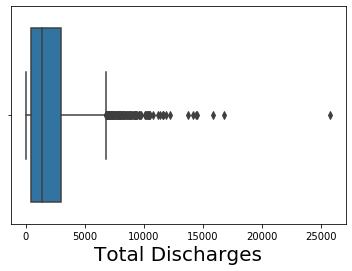

In [36]:
sns.boxplot(x=f6)

In [37]:
data[data['Provider Id']==100007].head()

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Average Copay
164,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,100007,FLORIDA HOSPITAL,601 E ROLLINS ST,ORLANDO,FL,32803,FL - Orlando,93,33949.48,6845.37,5042.31,1803.06
1251,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,100007,FLORIDA HOSPITAL,601 E ROLLINS ST,ORLANDO,FL,32803,FL - Orlando,224,26941.47,6077.88,5134.23,943.65
2581,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,100007,FLORIDA HOSPITAL,601 E ROLLINS ST,ORLANDO,FL,32803,FL - Orlando,180,69499.64,13645.76,12186.08,1459.68
4353,065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,100007,FLORIDA HOSPITAL,601 E ROLLINS ST,ORLANDO,FL,32803,FL - Orlando,303,40242.49,7670.97,6158.75,1512.22
6530,066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,100007,FLORIDA HOSPITAL,601 E ROLLINS ST,ORLANDO,FL,32803,FL - Orlando,159,30804.42,5934.77,3819.25,2115.52


## Insight: Florida Hospital has an extremely high number of discharge. It should be heavily monitor for any opportunity of fraud.

# F7 Find the hospital that has the highest value of money transaction

In [38]:
f7 = data.copy()
f7['Totalvalue']= f7['Total Discharges'] * f7['Average Total Payments']
g7 = f7.groupby('Provider Id')['Totalvalue'].sum().sort_values(ascending=False)
g7

Provider Id
330101    2.870070e+08
100007    2.361069e+08
330059    2.086041e+08
330024    1.889552e+08
50625     1.595431e+08
              ...     
10102     5.822700e+04
450865    5.725395e+04
230279    5.604000e+04
190161    5.244000e+04
140301    4.232393e+04
Name: Totalvalue, Length: 3337, dtype: float64

In [39]:
data[data['Provider Id'].isin([330101,100007,330059,330024])]['Provider Name'].unique()

array(['FLORIDA HOSPITAL', 'MOUNT SINAI HOSPITAL',
       'MONTEFIORE MEDICAL CENTER', 'NEW YORK-PRESBYTERIAN HOSPITAL'],
      dtype=object)

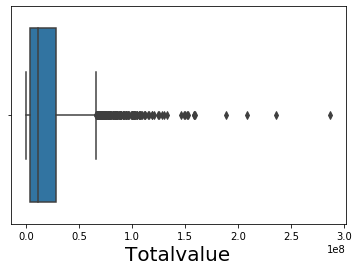

In [40]:
sns.boxplot(x=g7)

In [41]:
# the providers that have the largest number of total value are the following
l7 = g7[g7>1.889552e+08]
l7

Provider Id
330101    2.870070e+08
100007    2.361069e+08
330059    2.086041e+08
330024    1.889552e+08
Name: Totalvalue, dtype: float64

In [42]:
# the providers that have the highest value per discharge are the following
data['Totalvalue'] = data['Total Discharges'] * data['Average Total Payments']
f77 = data.groupby('Provider Id')['Totalvalue'].sum()/data.groupby('Provider Id')['Total Discharges'].sum()
f77.sort_values(ascending = False)

Provider Id
490142    50552.610000
450880    38418.529940
60096     35063.091250
50528     25181.728447
530015    23968.121667
              ...     
230279     3736.000000
340168     3639.470000
450813     3623.440000
250151     3510.752126
110209     3291.310000
Length: 3337, dtype: float64

[Text(0.5, 0, 'Average Payment Per Discharge')]

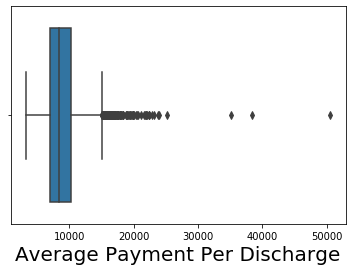

In [43]:
sns.boxplot(x=f77).set(xlabel='Average Payment Per Discharge')

In [44]:
l77 =  f77[f77>30000].index.tolist()
l77

[60096, 450880, 490142]

## Insight: # the providers that have the highest value per discharge are the following [60096(Specialized in Spinal Fusion and Major joint replacement), 450880(Specialized in Spinal Fusion and Major joint replacement), 490142(RESPIRATORY SYSTEM DIAGNOSIS)]

## Extended: Is respiratory System Diagnosis charge normal? Compare to average.

In [45]:
data[data['Provider Id']==60096].head()

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Average Copay,Totalvalue
109190,460 - SPINAL FUSION EXCEPT CERVICAL W/O MCC,60096,VAIL VALLEY MEDICAL CENTER,181 W MEADOW DRIVE,VAIL,CO,81657,CO - Denver,18,98351.72,54260.50,53196.66,1063.84,976689.00
111674,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,60096,VAIL VALLEY MEDICAL CENTER,181 W MEADOW DRIVE,VAIL,CO,81657,CO - Denver,78,53479.92,30632.92,26689.67,3943.25,2389367.76


In [46]:
data[data['Provider Id']==450880]

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Average Copay,Totalvalue
110200,460 - SPINAL FUSION EXCEPT CERVICAL W/O MCC,450880,BAYLOR SURGICAL HOSPITAL AT FORT WORTH,750 12TH AVENUE,FORT WORTH,TX,76104,TX - Fort Worth,38,124687.42,47531.05,35456.89,12074.16,1806179.90
113739,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,450880,BAYLOR SURGICAL HOSPITAL AT FORT WORTH,750 12TH AVENUE,FORT WORTH,TX,76104,TX - Fort Worth,113,39467.76,38686.28,9787.89,28898.39,4371549.64
114780,473 - CERVICAL SPINAL FUSION W/O CC/MCC,450880,BAYLOR SURGICAL HOSPITAL AT FORT WORTH,750 12TH AVENUE,FORT WORTH,TX,76104,TX - Fort Worth,16,53504.87,14885.31,11297.18,3588.13,238164.96


In [47]:
pd.set_option('display.max_colwidth', -1)
data[data['Provider Id']==490142]['DRG Definition']

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


40559    207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATOR SUPPORT 96+ HOURS
Name: DRG Definition, dtype: object

In [48]:
f71 = data[data['DRG Definition']=='207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATOR SUPPORT 96+ HOURS'].copy()
f71['mean_charges'] = f71.groupby('Provider Id')['Totalvalue'].sum()/f71.groupby('Provider Id')['Total Discharges'].sum()
f71.sort_values(by='mean_charges',ascending=False)
f71['mean_charges'].describe()

count    15.000000   
mean     31475.028000
std      3483.645905 
min      27364.270000
25%      29388.550000
50%      30636.200000
75%      33026.555000
max      41460.770000
Name: mean_charges, dtype: float64

## Insight: UVA Health Sciences Center is significant different than the mean in the same DRG category

# Grouby DRG
***

# F8 pick out the DRG groups that have the highest standard deviation for Average Total Payments, then examine by state

In [49]:
#groupby DRG, slice by Average total payment, sort by std
f8 = data.groupby(['DRG Definition'])['Average Total Payments'].describe()
f8.sort_values(by='std', ascending = False, inplace = True)
f8 = f8[f8['std']>10000]
f8.reset_index(inplace=True)
l8 =f8['DRG Definition'].tolist()
l8

['870 - SEPTICEMIA OR SEVERE SEPSIS W MV 96+ HOURS',
 '853 - INFECTIOUS & PARASITIC DISEASES W O.R. PROCEDURE W MCC',
 '207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATOR SUPPORT 96+ HOURS']

In [50]:
#pick out the top three diseases and groupby state
f81 = data[data['DRG Definition'].isin(l8)].copy()
f81 = f81.groupby(['DRG Definition','Provider State'])['Average Total Payments'].describe()

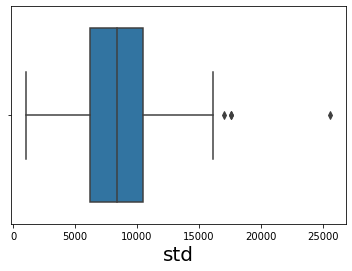

In [51]:
# 853 in DC has the largest amount of variation, list its own variation
f81 = f81.sort_values(by= 'std', ascending = False)
sns.boxplot(data=f81,x='std')

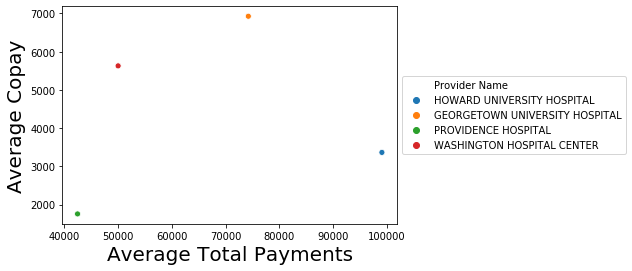

In [52]:
# In DC, illness 853 has a large variation in Total Payments among different hospitals. 
f82 = data[(data['Provider State']=='DC')&(data['DRG Definition']=='853 - INFECTIOUS & PARASITIC DISEASES W O.R. PROCEDURE W MCC')]
# As shown in the chart, the same service in DC may range around 40,000 to 98,000. 
# while the more expensive Total Payment may not incur more Average Copay cost.
s = sns.scatterplot(x='Average Total Payments' , y='Average Copay' , hue='Provider Name', data=f82)
s.legend(loc='center left', bbox_to_anchor=(1., 0.5), ncol=1)

In [53]:
f83 = data[(data['Provider State']=='CA')&(data['DRG Definition']=='207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATOR SUPPORT 96+ HOURS')]
f83.head()

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Average Copay,Totalvalue
39485,207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATOR SUPPORT 96+ HOURS,50002,ST ROSE HOSPITAL,27200 CALAROGA AVE,HAYWARD,CA,94545,CA - Alameda County,13,355395.53,63218.00,61552.84,1665.16,821834.00
39486,207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATOR SUPPORT 96+ HOURS,50006,ST JOSEPH HOSPITAL,2700 DOLBEER ST,EUREKA,CA,95501,CA - Redding,12,223054.33,41826.91,40986.00,840.91,501922.92
39487,207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATOR SUPPORT 96+ HOURS,50017,MERCY GENERAL HOSPITAL,4001 J ST,SACRAMENTO,CA,95819,CA - Sacramento,11,290215.27,53218.45,42362.72,10855.73,585402.95
39488,207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATOR SUPPORT 96+ HOURS,50022,RIVERSIDE COMMUNITY HOSPITAL,4445 MAGNOLIA AVENUE,RIVERSIDE,CA,92501,CA - San Bernardino,27,353588.59,48591.37,48208.33,383.04,1311966.99
39489,207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATOR SUPPORT 96+ HOURS,50025,UNIVERSITY OF CALIFORNIA SAN DIEGO MEDICAL CENTER,200 WEST ARBOR DRIVE,SAN DIEGO,CA,92103,CA - San Diego,19,172207.05,57509.68,56303.42,1206.26,1092683.92


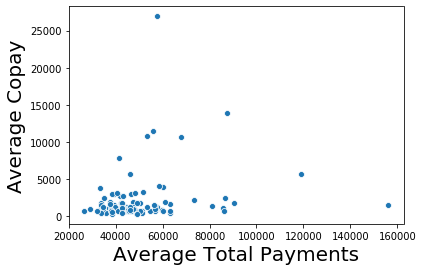

In [54]:
#the outlier problem is greater in Califronia for illness 207. 
f83 = data[(data['Provider State']=='CA')&(data['DRG Definition']=='207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATOR SUPPORT 96+ HOURS')]
s = sns.scatterplot(x='Average Total Payments' , y='Average Copay' , data=f83)

In [55]:
f83.sort_values(by='Average Total Payments', ascending = False)[0:2]

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Average Copay,Totalvalue
39562,207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATOR SUPPORT 96+ HOURS,50441,STANFORD HOSPITAL,300 PASTEUR DRIVE,STANFORD,CA,94305,CA - San Mateo County,11,929118.90,156158.18,154620.81,1537.37,1717739.98
39529,207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATOR SUPPORT 96+ HOURS,50195,WASHINGTON HOSPITAL,2000 MOWRY AVE,FREMONT,CA,94538,CA - Alameda County,11,918023.18,119113.00,113462.09,5650.91,1310243.00


## Insight: the above two hospitals in California charge an abnormally expensive amount for 207, and there is very low average copay. They should be monitored. 

# F9 Examine which State's mean Total Discharges is significantly different from national average.

In [56]:
# get mean Discharges by DRG by State
# calculate national average and national standard deviation for Discharges by DRG
# rename the column
f9 = data.groupby(['DRG Definition','Provider State'])['Total Discharges'].mean()
f99 = data.groupby(['DRG Definition'])['Total Discharges'].mean()
f999 =  pd.merge( f9.reset_index(),f99.reset_index(), on= 'DRG Definition' )
f98 = f999.groupby('DRG Definition')['Total Discharges_x'].describe()['std']
f999 =  pd.merge( f999,f98.reset_index(), on= 'DRG Definition' )
f999.rename(columns = {'Total Discharges_y' : 'National Average','Total Discharges_x':'State Average'}, inplace = True)
f999.head()

,DRG Definition,Provider State,State Average,National Average,std
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,AK,23.000000,31.145505,9.851635
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,AL,38.217391,31.145505,9.851635
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,AR,40.750000,31.145505,9.851635
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,AZ,25.250000,31.145505,9.851635
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,CA,25.597015,31.145505,9.851635


In [57]:
f999['Distance'] = (f999['State Average']-f999['National Average'])/f999['std']
f999.sort_values(by='Distance', ascending= True).head()

,DRG Definition,Provider State,State Average,National Average,std,Distance
3062,"391 - ESOPHAGITIS, GASTROENT & MISC DIGEST DISORDERS W MCC",WY,11.000000,27.405096,5.541926,-2.960180
364,101 - SEIZURES W/O MCC,HI,12.333333,30.667922,6.472431,-2.832721
3023,"391 - ESOPHAGITIS, GASTROENT & MISC DIGEST DISORDERS W MCC",HI,12.000000,27.405096,5.541926,-2.779737
2219,305 - HYPERTENSION W/O MCC,ID,11.000000,22.325066,4.238252,-2.672108
2242,305 - HYPERTENSION W/O MCC,OR,11.000000,22.325066,4.238252,-2.672108


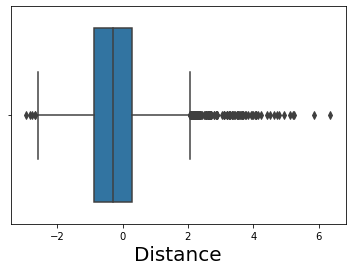

In [58]:
sns.boxplot(x= 'Distance', data = f999)

In [59]:
f999[f999['Distance']>5].sort_values(by='Distance', ascending=False).head()

,DRG Definition,Provider State,State Average,National Average,std,Distance
1817,"286 - CIRCULATORY DISORDERS EXCEPT AMI, W CARD CATH W MCC",DC,126.000000,23.978022,16.041062,6.360051
2970,390 - G.I. OBSTRUCTION W/O CC/MCC,DE,57.666667,21.730876,6.122866,5.869113
814,193 - SIMPLE PNEUMONIA & PLEURISY W MCC,DE,135.600000,49.704466,16.389019,5.241042
1647,254 - OTHER VASCULAR PROCEDURES W/O CC/MCC,SD,87.666667,28.679348,11.273616,5.232334
4982,948 - SIGNS & SYMPTOMS W/O MCC,DE,73.500000,28.115449,8.874971,5.113769


In [60]:
data[(data['DRG Definition']=='286 - CIRCULATORY DISORDERS EXCEPT AMI, W CARD CATH W MCC')&(data['Provider State']=='DC')]

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Average Copay,Totalvalue
57887,"286 - CIRCULATORY DISORDERS EXCEPT AMI, W CARD CATH W MCC",90011,WASHINGTON HOSPITAL CENTER,110 IRVING ST NW,WASHINGTON,DC,20010,DC - Washington,126,59858.69,17268.81,15939.25,1329.56,2175870.06


In [61]:
data[(data['DRG Definition']=='193 - SIMPLE PNEUMONIA & PLEURISY W MCC')&(data['Provider State']=='DE')]

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Average Copay,Totalvalue
29429,193 - SIMPLE PNEUMONIA & PLEURISY W MCC,80001,"CHRISTIANA CARE HEALTH SERVICES, INC.",4755 OGLETOWN-STANTON ROAD,NEWARK,DE,19718,DE - Wilmington,234,25067.79,11403.29,10007.81,1395.48,2668369.86
29430,193 - SIMPLE PNEUMONIA & PLEURISY W MCC,80003,ST FRANCIS HOSPITAL,7TH AND CLAYTON STS,WILMINGTON,DE,19805,DE - Wilmington,29,24074.13,10244.93,9311.41,933.52,297102.97
29431,193 - SIMPLE PNEUMONIA & PLEURISY W MCC,80004,BAYHEALTH - KENT GENERAL HOSPITAL,640 S STATE STREET,DOVER,DE,19901,DE - Wilmington,250,25076.32,9880.93,8585.10,1295.83,2470232.50
29432,193 - SIMPLE PNEUMONIA & PLEURISY W MCC,80006,NANTICOKE MEMORIAL HOSPITAL,801 MIDDLEFORD RD,SEAFORD,DE,19973,MD - Salisbury,46,18153.65,11392.93,10341.34,1051.59,524074.78
29433,193 - SIMPLE PNEUMONIA & PLEURISY W MCC,80007,BEEBE MEDICAL CENTER,424 SAVANNAH RD,LEWES,DE,19958,MD - Salisbury,119,27795.93,9058.10,8076.16,981.94,1077913.90


## Insight: The reason for DC to have above average Total Discharge is becase there is only one hospital that treats this disease in the entire DC area. However, the average hospitals in the country only operates 24 cases. It means that DC has a shortage of medical expertise in this area. Deleware seems to have a concentrated medical discharges for DRG 390,193,948. The average Total Discharges for all hospitals in Deleware for those DRG are significantly above national Total Discharge Averages

# F10 Most frequent illness and the average cost of this illness

In [62]:
f10 = data.groupby('DRG Definition')['Total Discharges'].sum()
f10 = f10.sort_values()
f101 = data.groupby('DRG Definition')['Average Total Payments'].mean()
f101.sort_values()
f10 = pd.merge(f10 , f101, on='DRG Definition')
f10.rename(columns = {'Total Discharges':'Count'}, inplace = True)
f10.head()

,Count,Average Total Payments
DRG Definition,,
419 - LAPAROSCOPIC CHOLECYSTECTOMY W/O C.D.E. W/O CC/MCC,16157,8068.090218
203 - BRONCHITIS & ASTHMA W/O CC/MCC,16577,4389.910134
301 - PERIPHERAL VASCULAR DISORDERS W/O CC/MCC,16744,4599.646499
917 - POISONING & TOXIC EFFECTS OF DRUGS W MCC,16952,10763.814413
315 - OTHER CIRCULATORY SYSTEM DIAGNOSES W CC,17478,7020.108370


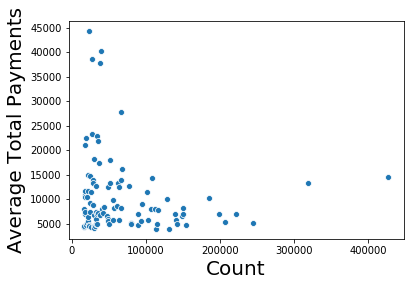

In [63]:
# no correlation
# There is a group of diseases that are not very frequent, but very expensive to treat. They are on the upper-left corner.
sns.scatterplot(x='Count', y='Average Total Payments' ,data=f10)

In [64]:
# These are the rare diseases that are very costly but rare
f10[f10['Average Total Payments']>35000]

,Count,Average Total Payments
DRG Definition,,
870 - SEPTICEMIA OR SEVERE SEPSIS W MV 96+ HOURS,22624,44259.485463
207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATOR SUPPORT 96+ HOURS,26412,38588.920997
329 - MAJOR SMALL & LARGE BOWEL PROCEDURES W MCC,37250,37765.594295
853 - INFECTIOUS & PARASITIC DISEASES W O.R. PROCEDURE W MCC,39482,40315.961432


In [65]:
# Examine the common illness
f10[f10['Count']>300000]

,Count,Average Total Payments
DRG Definition,,
871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ HOURS W MCC,319072,13238.823385
470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT OF LOWER EXTREMITY W/O MCC,427207,14566.929215


## Insight: there is no obvious correlation between the frequency of the disease and the cost of the disease. However, there is a group of rare disease that is very costly, and there is a group of disease that is very common. Although some illnesses are very similar to one another, the cost of these illness may vary greatly, which may be susceptible to wrong billing (870 & 871).

# Groupby State
***

## F11: it prompts me to see why is there a huge difference between 870 and 871

In [66]:
f11a = data.groupby(['Provider State','DRG Definition'])['Total Discharges'].mean().copy()
f11a = f11a.reset_index()

In [67]:
# calculate national mean average for the number of Total Discharges for each disease
f11b = data.groupby('DRG Definition')['Total Discharges'].mean().copy()
f11b = f11b.reset_index()

In [68]:
# combine the two charts
f11 = pd.merge(f11a, f11b, on='DRG Definition', how='left')
f11.rename(columns={'Total Discharges_x':'State Average','Total Discharges_y':'National Average'},inplace = True)
f11.head()

,Provider State,DRG Definition,State Average,National Average
0,AK,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,23.000000,31.145505
1,AK,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/O MCC,11.000000,25.155704
2,AK,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFARCTION W MCC,22.500000,37.427969
3,AK,065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFARCTION W CC,25.333333,46.899074
4,AK,066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFARCTION W/O CC/MCC,21.000000,30.924142


In [69]:
f11['State/National'] = (f11['State Average']/f11['National Average'])
f11.sort_values(by='State/National',ascending=False).head()

,Provider State,DRG Definition,State Average,National Average,State/National
714,DC,"286 - CIRCULATORY DISORDERS EXCEPT AMI, W CARD CATH W MCC",126.000000,23.978022,5.254812
707,DC,251 - PERC CARDIOVASC PROC W/O CORONARY ARTERY STENT W/O MCC,133.500000,39.316369,3.395532
4141,SD,885 - PSYCHOSES,497.000000,146.383361,3.395195
4078,SD,254 - OTHER VASCULAR PROCEDURES W/O CC/MCC,87.666667,28.679348,3.056787
1656,KS,885 - PSYCHOSES,415.666667,146.383361,2.839576


In [70]:
f11['State/National'].mean()

0.9444752408233614

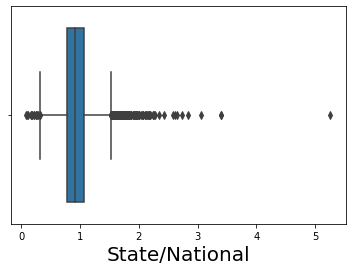

In [71]:
sns.boxplot(x='State/National', data=f11)

In [72]:
data[(data["DRG Definition"]=='286 - CIRCULATORY DISORDERS EXCEPT AMI, W CARD CATH W MCC')&(data['Provider State']=='DC')]

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Average Copay,Totalvalue
57887,"286 - CIRCULATORY DISORDERS EXCEPT AMI, W CARD CATH W MCC",90011,WASHINGTON HOSPITAL CENTER,110 IRVING ST NW,WASHINGTON,DC,20010,DC - Washington,126,59858.69,17268.81,15939.25,1329.56,2175870.06


In [73]:
data[(data["DRG Definition"]=='251 - PERC CARDIOVASC PROC W/O CORONARY ARTERY STENT W/O MCC')&(data['Provider State']=='DC')]

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Average Copay,Totalvalue
49303,251 - PERC CARDIOVASC PROC W/O CORONARY ARTERY STENT W/O MCC,90001,GEORGE WASHINGTON UNIV HOSPITAL,900 23RD ST NW,WASHINGTON,DC,20037,DC - Washington,13,71804.00,15860.38,15168.69,691.69,206184.94
49304,251 - PERC CARDIOVASC PROC W/O CORONARY ARTERY STENT W/O MCC,90011,WASHINGTON HOSPITAL CENTER,110 IRVING ST NW,WASHINGTON,DC,20010,DC - Washington,254,56789.05,14942.24,13956.53,985.71,3795328.96


## Insight: One DC Hospital has five times the number of Total Discharges than national average for the DRG code 286. That same hospital is also above national average for DRG code 251

# F12 Total Payments by state

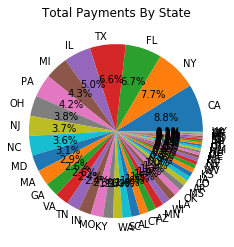

In [74]:
f12 = data.groupby('Provider State')['Totalvalue'].sum()
f12 = f12.sort_values(ascending=False).reset_index()
my_data = f12['Totalvalue']
my_labels = f12['Provider State']
plt.pie(my_data,labels=my_labels,autopct='%1.1f%%')
plt.title('Total Payments By State')
plt.show()

In [75]:
f12['Percentage'] = f12['Totalvalue']/f12['Totalvalue'].sum()
f12['Cumsum'] = f12['Percentage'].cumsum()
f12.head(9)

,Provider State,Totalvalue,Percentage,Cumsum
0,CA,5.862212e+09,0.087903,0.087903
1,NY,5.117373e+09,0.076734,0.164637
2,FL,4.499882e+09,0.067475,0.232113
3,TX,4.417583e+09,0.066241,0.298354
4,IL,3.327673e+09,0.049898,0.348252
5,MI,2.885783e+09,0.043272,0.391524
6,PA,2.831209e+09,0.042454,0.433977
7,OH,2.533346e+09,0.037987,0.471964
8,NJ,2.462088e+09,0.036919,0.508883


## Insight: Top 9 stats account for over 50% of the medical payments. 

# Groupby Zipcode

# F13


In [76]:
# (average total average payments)* the number of rows/ the number of rows
data.groupby(['Provider Zip Code'])['Average Total Payments'].describe()

,count,mean,std,min,25%,50%,75%,max
Provider Zip Code,,,,,,,,
1040,59.0,7842.748814,4420.547293,3655.33,4986.1950,6587.110,9028.5350,30821.81
1060,62.0,7308.722742,5743.264557,3476.47,4465.6800,5738.990,7322.7475,40336.90
1069,38.0,5726.230000,2175.517615,3286.18,4304.3400,4902.460,6647.4275,12479.26
1082,13.0,5657.301538,1718.406255,4014.90,4486.0800,5074.200,6280.5100,10528.50
1085,36.0,6413.707222,2599.233940,3284.00,4293.1450,5881.920,7383.9300,12849.23
...,...,...,...,...,...,...,...,...
99645,32.0,11597.576563,5137.754193,6624.84,7756.4550,10234.815,13104.6175,27026.25
99669,18.0,11535.552778,5131.618121,6336.18,7674.5350,9917.460,12777.0275,22908.23
99701,29.0,19966.092759,13714.302916,7776.91,12548.5700,14215.730,25443.0000,77566.38


In [77]:
# for every row, sum((total discharges)*(average total average payments))/sum(total discharges)
# this is a more valid average
f13 = data.groupby(['Provider Zip Code'])['Totalvalue'].sum()/data.groupby(['Provider Zip Code'])['Total Discharges'].sum()
f13.sort_values(ascending = False, inplace=True)
f13

Provider Zip Code
81657    35063.091250
93635    25181.728447
83001    23968.121667
94305    23122.697493
80487    22477.277500
             ...     
60452    3847.630000 
48116    3736.000000 
28401    3639.470000 
78017    3623.440000 
31788    3291.310000 
Length: 3053, dtype: float64

In [78]:
f13.mean()

8811.115005090865

In [79]:
f13.iloc[0:5].index.tolist()

[81657, 93635, 83001, 94305, 80487]

## The above list contains the top 5 zipcode that have the most expensive average payment

# F14 Which zip code has the highest Medicare covererage the most in dollar amount?

In [80]:
data['Coverage'] = data['Average Medicare Payments']/data['Average Total Payments']

In [81]:
# zip 93635 has the highest mean medicare coverage
f14 = data.groupby('Provider Zip Code')['Coverage'].describe()
f14.sort_values(by='mean').head()

,count,mean,std,min,25%,50%,75%,max
Provider Zip Code,,,,,,,,
60099,2.0,0.374348,0.086351,0.313288,0.343818,0.374348,0.404877,0.435407
75063,1.0,0.472517,NaN,0.472517,0.472517,0.472517,0.472517,0.472517
19124,3.0,0.483417,0.167938,0.307033,0.404428,0.501824,0.571609,0.641394
96819,9.0,0.508343,0.232152,0.195380,0.272098,0.549514,0.656069,0.882069
77094,1.0,0.641385,NaN,0.641385,0.641385,0.641385,0.641385,0.641385


In [82]:
# zipcodes that has more frequent inpatients are highly covered by medicare
f14.sort_values(by='count', ascending=False, inplace = True)
f14.head()

,count,mean,std,min,25%,50%,75%,max
Provider Zip Code,,,,,,,,
76104,317.0,0.846800,0.084192,0.253007,0.792344,0.861176,0.903593,0.987553
77030,282.0,0.814772,0.124452,0.325395,0.753423,0.844204,0.913423,0.986185
72205,268.0,0.840933,0.082534,0.426232,0.799160,0.851092,0.908366,0.978465
40202,248.0,0.859698,0.072385,0.552566,0.809941,0.869705,0.917370,0.983990
79902,247.0,0.844648,0.083942,0.573450,0.790405,0.858159,0.913279,0.984743


In [83]:
f14['count'].sum()

163065.0

# F15

In [84]:
f15 = data.groupby('Hospital Referral Region Description')['Hospital Referral Region Description'].count().sort_values()
f15

Hospital Referral Region Description
ND - Minot           64  
ND - Grand Forks     80  
WI - Neenah          83  
OR - Bend            85  
ID - Idaho Falls     85  
                     ..  
PA - Philadelphia    2554
TX - Houston         2577
GA - Atlanta         2630
MA - Boston          2910
CA - Los Angeles     3653
Name: Hospital Referral Region Description, Length: 306, dtype: int64

## The region of ND-Minot has the least number of referrals

In [85]:
data[data['Provider State']=='ND'].head()

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Average Copay,Totalvalue,Coverage
733,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,350002,ST ALEXIUS MEDICAL CENTER,900 E BROADWAY,BISMARCK,ND,58501,ND - Bismarck,29,12795.10,6032.34,5213.72,818.62,174937.86,0.864295
734,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,350006,TRINITY HOSPITALS,407 3RD ST SE,MINOT,ND,58701,ND - Minot,13,16446.38,6356.15,5418.00,938.15,82629.95,0.852403
735,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,350011,SANFORD MEDICAL CENTER FARGO,801 BROADWAY NORTH,FARGO,ND,58122,ND - Fargo/Moorhead MN,47,13070.61,6614.57,5611.40,1003.17,310884.79,0.848339
736,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,350015,MEDCENTER ONE,300 N 7TH ST,BISMARCK,ND,58506,ND - Bismarck,54,11360.66,6349.31,5306.00,1043.31,342862.74,0.835681
737,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,350019,ALTRU HOSPITAL,1200 S COLUMBIA RD,GRAND FORKS,ND,58201,ND - Grand Forks,17,16553.17,6716.05,5920.76,795.29,114172.85,0.881584
